# geoML

So I wanted to create a seamless tutorial for taking OpenStreetMap (OSM) vector data and converting it for use with machine learning (ML) models. In particular, I am really interested in creating a tight, clean pipeline for disaster relief applications, where we can use something like crowd sourced building polygons from OSM to train a supervised object detector to discover buildings in an unmapped location.

The recipe for building a basic deep learning object detector is to have two components: (1) training data (image (raster) + label (vector) pairs) and (2) model framework. The deep learning model itself will be a Single Shot Detector (SSD) object detector. We will use OSM polygons as the basis of our label data and Digital Globe imagery for the raster data. We won't go into the details of an SSD here, as there are plenty sources available. We will run the object detector in <a href='https://aws.amazon.com/sagemaker/'>AWS Sagemaker</a>. 

In this part I you will:



```
1. Get vector data from OSM
2. Convert them to labels for a CNN object detection (using Apache MXNET)
3. Store them in VOC style 
4. Create optimized .rec files for porting them into the AWS Sagemaker world
5. AWS S3 & EC2 
```

In the second notebook in this repo, you will find the details on training the ML model itself once we create a training data set.


### Upfront: what I am throwing at you and where things sit in this ecosystem
![](assets/geoML.png)


# OSM vector data as ML training labels
## Cyclone Kenneth 2019-04-25
### Part I

I anticpate using this tutorial in conjunction with <a href='https://www.hotosm.org'>HOT-OSM</a> related tasks -- where we may have drawn vector data as part of a specific project and know it exists. For the purpose of establishing a demo, we will use a recent HOT OSM task area that was impacted by Cyclone Kenneth in 2019, Nzwani, Comores. 

![](assets/comores.png)
![](assets/kenneth2019.png)
![](assets/osm_deets.png)

In order to train an ML model, specifically for detecting objects like buildings, we will need the vector polygons from OSM and corresponding imagery. OSM is freely available data. The imagery we require is often not freely available, however <a href='https://www.digitalglobe.com/ecosystem/open-data/'>Digital Globe has Open Data</a> imagery for many of these natural disasters. So we can grab that data for this application (a little later on).

I decided to use the <a href='https://automating-gis-processes.github.io/2017/lessons/L7/retrieve-osm-data.html'>OSMNX</a> python library for interfacing with OSM (which can be a bit daunting otherwise). Based on the HOT-OSM task, Nzwani Centre, Comores was labeled as an 'Urgent' location (see table above). So I'm going to start there because it seems like a lot of training data could be available. 



In [1]:
%matplotlib inline
import osmnx as ox
import matplotlib.pyplot as plt

place_name = "Nzwani Centre, Comores"
graph = ox.graph_from_place(place_name, which_result=2)  


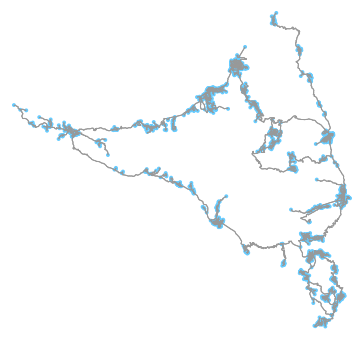

In [2]:
fig, ax = ox.plot_graph(graph)


This figure shows all the nodes and edges, or 'DiGraph' (as OSMNX refers to it) for the line features making up the road network in Nzwani. 

Let's also grab area extent (polygon), and the buildings (also polygons) and check out the data structures.

In [3]:
area = ox.gdf_from_place(place_name)
buildings = ox.buildings_from_place(place_name)
print(type(area),' Format of the areas')
print(type(buildings),' Format of the buildings')

<class 'geopandas.geodataframe.GeoDataFrame'>  Format of the areas
<class 'geopandas.geodataframe.GeoDataFrame'>  Format of the buildings


In [4]:
nodes, edges = ox.graph_to_gdfs(graph)

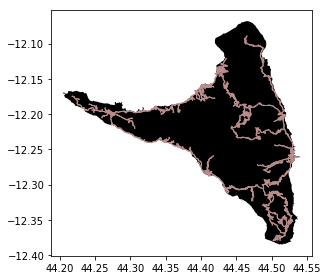

In [5]:
fig, ax = plt.subplots()
area.plot(ax=ax, facecolor='black')
edges.plot(ax=ax, linewidth=1, edgecolor='#BC8F8F')
buildings.plot(ax=ax, facecolor='khaki', alpha=0.7)
plt.tight_layout()

In [7]:
buildings.iloc[0]

addr:city                                                        NaN
amenity                                                          NaN
area                                                             NaN
building                                                         yes
building:levels                                                  NaN
denomination                                                     NaN
fixme                                                            NaN
geometry           POLYGON ((44.4299008 -12.1326273, 44.4302282 -...
height                                                           NaN
name                                                             NaN
name:ar                                                          NaN
nodes              [2327826398, 2327826399, 2327826396, 232782639...
note                                                             NaN
religion                                                         NaN
source                            

In [10]:
buildings=buildings[['geometry']]       
#buildings.to_file('buildings.geojson', driver='GeoJSON')

print('the number of buildings are: ',len(buildings))

the number of buildings are:  35862


So there are a lot of buildings here! We won't impose any specific attribute requirement, but we _could_ sort these based on some of the features available above in the dataframe. For now, we will take everything.

Let's grab some DG imagery. To create an object detector, we will mimic the <a href='http://host.robots.ox.ac.uk/pascal/VOC/'>VOC Pascal training data format</a>, where we require pairs of images (jpegs) and vector (xml) labels. The xml files are formated in a particular way. You can read about it (on this difficult to navigate) <a href='http://host.robots.ox.ac.uk/pascal/VOC/'>website</a>. 

I would prefer to pull the data directly from the Digital Globe Open Data website, but unforuntately at present, there seems to be no imagery that covers this area post-event. I really want to keep this location as a point of focus, given the amount of buildings we found and the relevance of this task. So, I will just separately download the necessary imagery and make it available for this purpose. You can find a sample geotif in the toplevel github repo.

Let me digress a little about the <a href='https://www.digitalglobe.com/ecosystem/open-data'>DG Open Data website</a>. This website is very difficult to search, and even though a huge amount of timely and relevant imagery is made available free for areas impacted by natural disasters, it is nearly impossible to search efficiently in a geospatial way. Bottom line, it is a little hard to determine which image may optimally contain a significant amount of buildings for the region I am interested in. My typical process would be to click through some thumbnails on the website and find a region with significant urban-looking growth. I sort of gave up after 20 minutes, and trying to guess where I was looking on the globe from the thumbnail. Assuming the DG Open Data has this image at some point in the future, the subsequent steps will still be consistent for any tif you download.

If you get data directly from the DG Open Data website, they are actually in the format of a Cloud Optimized Geotif (COG) which turn out to be super convenient to create a virtual raster (vrt) from. The benefit of this is that we can create a light-weight file that loads in a local QGIS window without downloading the entire tif. We can cut, subset, etc and just wind up with the image we want, and not supereflous regions. 

### (sidebar) vsicurl & the COG


In [27]:
import os
exists = os.path.isfile('foo.vrt')
if exists:
    os.system('rm foo.vrt')
    os.system('gdalbuildvrt foo.vrt /vsicurl/http://opendata.digitalglobe.com/cyclone-kenneth/pre-event/2017-10-28/103001007206B400/3023101.tif')
else:
    os.system('gdalbuildvrt foo.vrt /vsicurl/http://opendata.digitalglobe.com/cyclone-kenneth/pre-event/2017-10-28/103001007206B400/3023101.tif')

0

### Get the show on the road

We are not doing this above step this time, but the next steps are the same. 

We actually want to create an mbtiles file, which will allow us to unpack slippy tile, 256x256 image chips directly (perfect for ML training data). Then we will 'unpack' them from the mbtil container to create the actual image tiles.

In [11]:
import os
os.system('gdal_translate -of MBTiles nzwani_dg_wv3_05032019_104001004A465900.tif nzwani_dg_wv3_05032019_104001004A465900.mbtiles')

256

In [12]:
os.system('mb-util nzwani_dg_wv3_05032019_104001004A465900.mbtiles tiles/')

0

In [13]:
ls tiles

19/            metadata.json


This is a WV3 image with resolution 0.30-m/pix. Zoom level 19 is what we expect. We will need to carry this zoom level forward for all our label generation needs.

In [14]:
img='nzwani_dg_wv3_05032019_104001004A465900.tif'



make rectangles from OSM buildings vector file. We will intersect these with our original training data to get damaged bounding boxes


WHY IS IT SO HARD TO GET STORM TRACKS!!!?????!!!!! http://www.gdacs.org/resources.aspx?eventid=1000559&episodeid=4&eventtype=TC

In [24]:
%run -i 'utils/tile_box_funcs.py'
df=footprint2box(buildings)

Going shopping for all the slippymap TMS tile coverage with <a href='https://github.com/mapbox/supermercado'>Mapbox SUPERMERCADO!</a>

In [21]:
joined = supermercado_labels(df,19)

supermercado tile geojson created...  box_labels_supermarket.geojson
file exists, overwriting


![](assets/supermercado.png)
Slippymap tiles (brown)


![](assets/supermercado_bldg.png)
Slippymap tiles (brown) with our vector building rectangles (blue)



We want to create the Pascal VOC data structure. This is the easiest to ingest into a CNN Object Detector and has become a bit of a standard format.

```python

    VOC1900
        └─── Annotations/*xml
        └─── JPEGImages/*jpeg
        └─── ImageSets/
                       └─── Main/
                            └─── train.txt
                            └─── val.txt
```

In [25]:
tmsVOCxml('VOC1900/','buildings',joined)


In [37]:
flattenTMS('tiles/','19','VOC1900/')

In [49]:
#cleanupPairs('VOC1900/')

In [50]:
ls VOC1900/Annotations/*.xml | wc -l

      29


In [51]:
ls VOC1900/JPEGImages/*.jpg | wc -l

      29


For use with Sagemaker, or MxNet in general, you'll want to create a .rec file for the training and validation data. While not required for either, it is super convenient. This is a binary file format for bundling the data for training. I am not sure if this binary bundle has signficant advantages with respect to file input and output and memory optimization, but it may be argued as such. First we need to create a text list of just the prefixes of all the images. 

In [54]:
import os
os.system('find VOC1900/JPEGImages/ -name \'*.jpg\' -exec basename {} \; > list > list')  #(list all files into a tmp list, make sure the remove the .ext)
os.system('shuf list > tmp')                 #(shuffle the list and copy to tmp)
os.system('head -n 7 tmp > val.txt')        #(take the first 50 lines as the val.txt. The number 50 should be adjusted based on your dataset.)
os.system('tail -n +$(( 8 )) tmp > train.txt')  #(take the remaining lines as the train.txt)
if not os.path.exists('VOC1900/ImageSets/Main/'):
    os.makedirs('VOC1900/ImageSets/Main/')
os.system('mv train.txt VOC1900/ImageSets/Main/')
os.system('mv val.txt VOC1900/ImageSets/Main/')

# you'll need to remove the .jpg ext from the val.txt and the train.txt maybe using vim (:%s/*.jpg//g). I am not sure how to do that from the command line

0

In [55]:
run tools/prepare_dataset.py --dataset pascal --year 1900 --set train --target rec/train.lst --root "/Users/shay.strong/Documents/github/public/sagely"


3.7.3 (default, Mar 27 2019, 09:23:39) 
[Clang 10.0.0 (clang-1000.11.45.5)]
saving list to disk...
List file rec/train.lst generated...
Record file rec/train.rec generated...


<Figure size 432x288 with 0 Axes>

In [56]:
run tools/prepare_dataset.py --dataset pascal --year 1900 --set val --target rec/val.lst --root "/Users/shay.strong/Documents/github/public/sagely"



3.7.3 (default, Mar 27 2019, 09:23:39) 
[Clang 10.0.0 (clang-1000.11.45.5)]
saving list to disk...
List file rec/val.lst generated.....
Record file rec/val.rec generated...


These .rec binary files are memory optimized containers that we can transfer to AWS S3 so that Sagemaker can pick them up.